In [3]:
from src.utils import download_images

In [4]:
import pandas as pd
df = pd.read_csv('train.csv')

In [5]:
df_10 = df.sample(10)
df_10

,image_link,group_id,entity_name,entity_value
7106,https://m.media-amazon.com/images/I/8139VF3tG9...,318770,wattage,240.0 watt
82935,https://m.media-amazon.com/images/I/818UfF6cw2...,558374,item_weight,100 gram
199353,https://m.media-amazon.com/images/I/51ujoCaA-z...,368364,depth,7.9 centimetre
3649,https://m.media-amazon.com/images/I/61uTo4TOXM...,179080,wattage,250.0 watt
216264,https://m.media-amazon.com/images/I/51p6z3hU+9...,347320,depth,16.0 inch
185265,https://m.media-amazon.com/images/I/517QGUmQpm...,119607,depth,30.0 millimetre
154197,https://m.media-amazon.com/images/I/51kjS9-Lfc...,752266,depth,14.0 centimetre
198490,https://m.media-amazon.com/images/I/51Mh3RMYrc...,300630,depth,22.2 centimetre
137914,https://m.media-amazon.com/images/I/61EDpvl6Py...,244283,height,14.0 inch
253962,https://m.media-amazon.com/images/I/51mRAHY6y1...,966823,height,14.0 centimetre


In [6]:
images_links = df_10['image_link'].to_list()

In [7]:
download_images(images_links, "./sample_images", True)

Exception in thread Thread-5 (_handle_workers):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\manas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
  0%|          | 0/10 [00:00<?, ?it/s]    _threading_Thread_run(self)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\multiprocessing\pool.py", line 522, in _handle_workers
    cls._wait_for_updates(current_sentinels, change_notifier)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python

In [22]:
import cv2
import pytesseract
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to display multiple images in a grid
def display_images(images, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
    fig.suptitle(title, fontsize=16)
    
    for i, img in enumerate(images):
        ax = axes[i // 5, i % 5]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

# Initialize an array to store the images
image_directory = '81L5nXqWeLL.jpg'  # Correct directory path
image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory) if filename.endswith(('.png', '.jpg', '.jpeg'))]

original_images = [cv2.imread(path) for path in image_paths if cv2.imread(path) is not None]
original_images = [cv2.imread(path) for path in image_paths]

# Apply Otsu's binarization
binary_images = [cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] for img in original_images]
display_images(binary_images, "Binarized Images (Otsu's)")

# 4. Noise removal using Median Blur and display
denoised_images = [cv2.medianBlur(binary, 3) for binary in binary_images]
display_images(denoised_images, "Denoised Images (Median Blur)")

# 5. Dilation and display
kernel = np.ones((1, 1), np.uint8)
dilated_images = [cv2.dilate(denoised, kernel, iterations=1) for denoised in denoised_images]
display_images(dilated_images, "Dilated Images")

# 6. Erosion and display
eroded_images = [cv2.erode(dilated, kernel, iterations=1) for dilated in dilated_images]
display_images(eroded_images, "Eroded Images")

# 7. Skew Correction (rotation) and display
def correct_skew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

skew_corrected_images = [correct_skew(eroded) for eroded in eroded_images]
display_images(skew_corrected_images, "Skew Corrected Images")

# 8. Resize images (increase size for better OCR performance)
resized_images = [cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC) for image in skew_corrected_images]
display_images(resized_images, "Resized Images")

# 9. Invert colors for white text on black background (optional, based on image content)
inverted_images = [cv2.bitwise_not(image) for image in resized_images]
display_images(inverted_images, "Inverted Images (Optional)")

# 10. OCR Processing on each preprocessed image
ocr_results = []
for img in inverted_images:
    text = pytesseract.image_to_string(img)
    ocr_results.append(text)

# Output OCR results for each image
for idx, text in enumerate(ocr_results):
    print(f"Text from image {idx+1}:\n{text}\n")


NotADirectoryError: [WinError 267] The directory name is invalid: '81L5nXqWeLL.jpg'

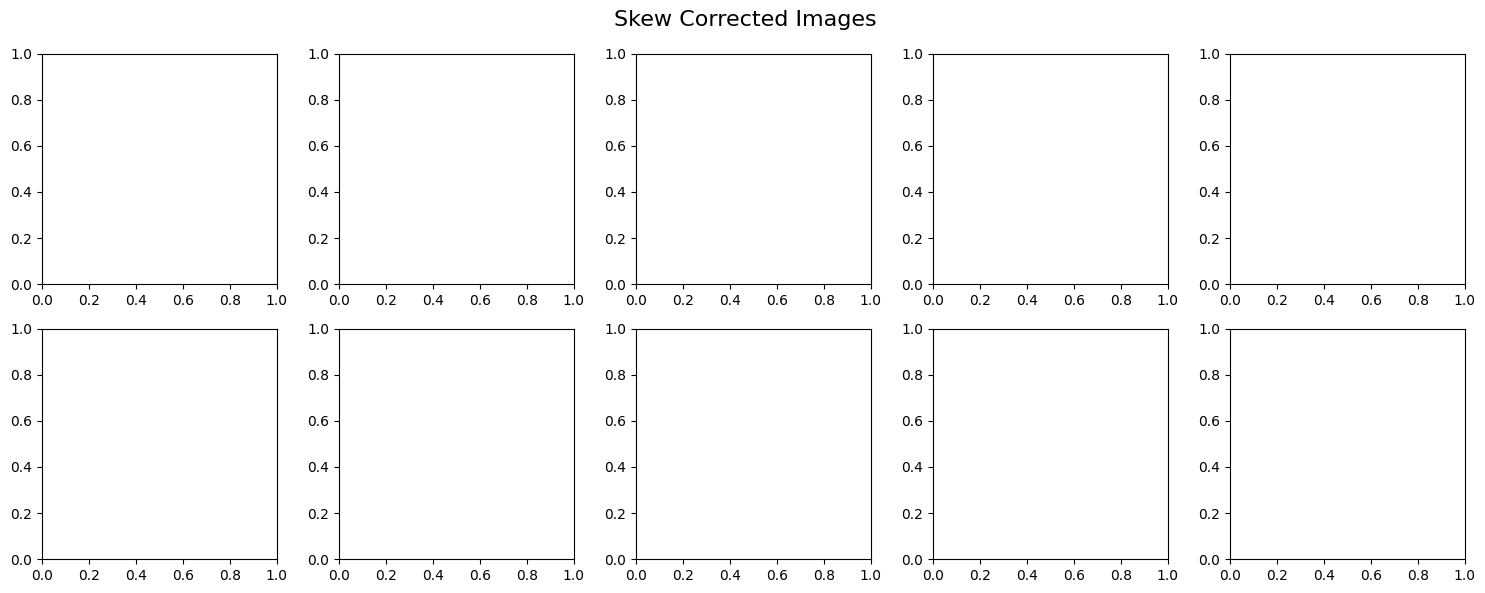

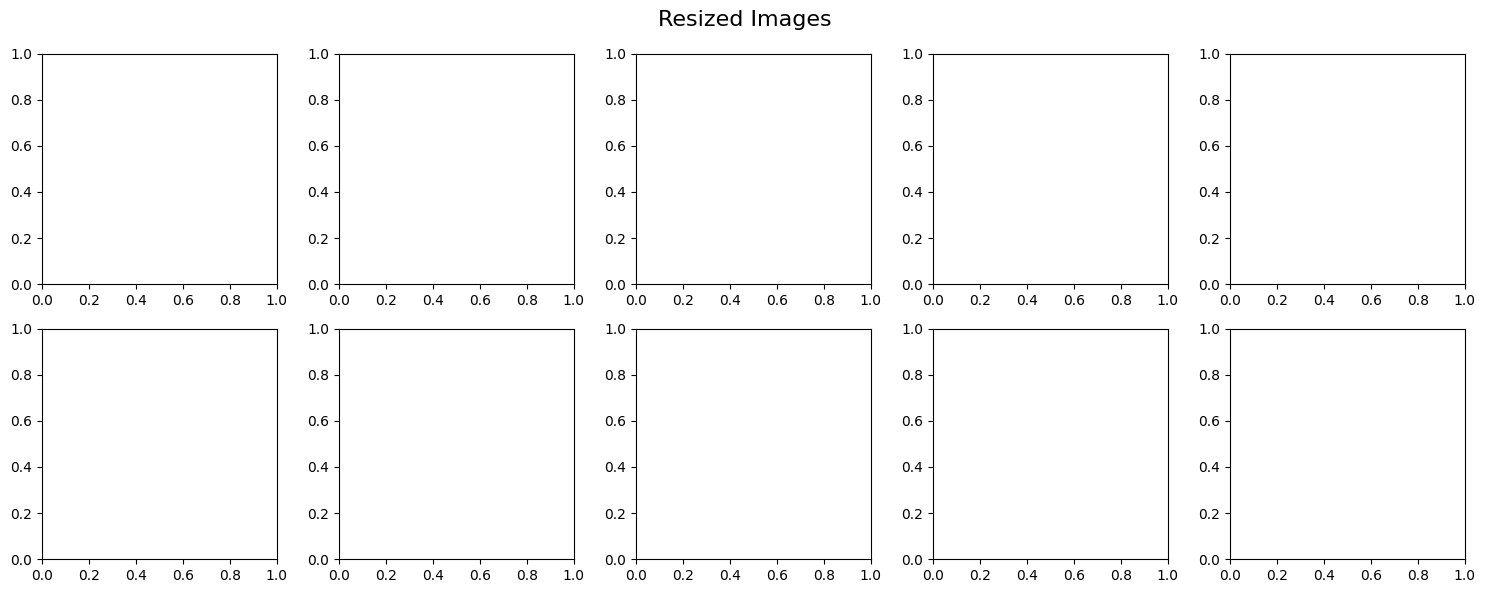

In [6]:
import numpy as np
import cv2

# Example definition of correct_skew function
def correct_skew(image):
    # Your skew correction logic here
    # This is just a placeholder example
    return image

eroded_images = [cv2.imread('41hriA7iZ+L.jpg', 0), cv2.imread('51lp9VNwRsL.jpg', 0)]

# Ensure all images are NumPy arrays
skew_corrected_images = [correct_skew(eroded) for eroded in eroded_images]
skew_corrected_images = [np.array(image) for image in skew_corrected_images if isinstance(image, np.ndarray)]

# Display skew corrected images
display_images(skew_corrected_images, "Skew Corrected Images")

# Resize images (increase size for better OCR performance)
resized_images = [cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC) for image in skew_corrected_images]

# Display resized images
display_images(resized_images, "Resized Images")

In [12]:
import pandas as pd
import os

In [13]:
df = pd.read_csv('train.csv')

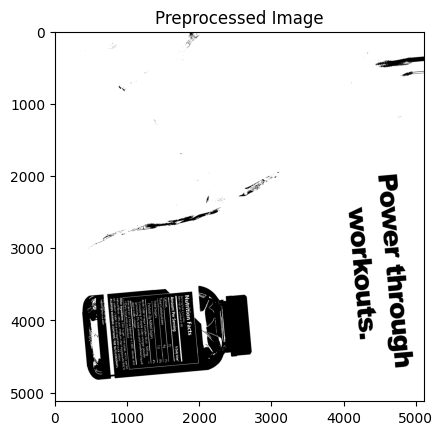

Text from image:
e e
Nutrition Facts
Serv ng Sze 2 Ganny
Serv rs Pe’ container 30

a . ' Amount Per Serving % Daily Value”

Calories
Total Carbohydrates

Total Sugars
[icluces 2g Added Sugars

- “F Apole ides Vinegat Complex (ruil! 509 mg
“ ve ‘a: Consisting o aople cider vinegar nowder

{proviGing 5% total acid) and unrefined liquid
app e cider vinega’

tPercent D2 y Va ue based or @ 27,066 calories dict
**Dally Va ue not established
Other ingredients: Gane gugat. cam SyfUP- warner, pectin.
natural flavor. citric acie, rredium char) tryglycerde {MCT)
oll, sodiuir c*trate. fruit and vegetable juice ‘calor
ALLERGEN WARNING: CONTAINS TREE NUTS (COCONUT).

Suppor @myk vus COM





In [24]:
import cv2
import pytesseract
import numpy as np
import os
import matplotlib.pyplot as plt

def process_image(image_path):
    # Read the image
    original_image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    
    # Apply Otsu's binarization
    binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    # Noise removal using Median Blur
    denoised_image = cv2.medianBlur(binary_image, 3)
    
    # Dilation
    kernel = np.ones((1, 1), np.uint8)
    dilated_image = cv2.dilate(denoised_image, kernel, iterations=1)
    
    # Erosion
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
    
    # Skew Correction (rotation)
    def correct_skew(image):
        coords = np.column_stack(np.where(image > 0))
        angle = cv2.minAreaRect(coords)[-1]
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return rotated
    
    skew_corrected_image = correct_skew(eroded_image)
    
    # Resize image (increase size for better OCR performance)
    resized_image = cv2.resize(skew_corrected_image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    
    # Invert colors for white text on black background (optional, based on image content)
    inverted_image = cv2.bitwise_not(resized_image)
    
    # OCR Processing
    text = pytesseract.image_to_string(inverted_image)
    
    # Display the preprocessed image and OCR result
    plt.imshow(inverted_image, cmap='gray')
    plt.title("Preprocessed Image")
    plt.show()
    print(f"Text from image:\n{text}\n")

# Example usage:
image_path = '81L5nXqWeLL.jpg'
process_image(image_path)

In [20]:
filtered_df = df.loc[df['image_link'] == "https://m.media-amazon.com/images/I/81L5nXqWeLL.jpg"]
download_images([['image_link'][]], ".",True)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2692662769.py, line 2)